## Comparison between the stability of the 3 geodesic shootings schemes proposed for LDDMM



You can open your pictures here. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


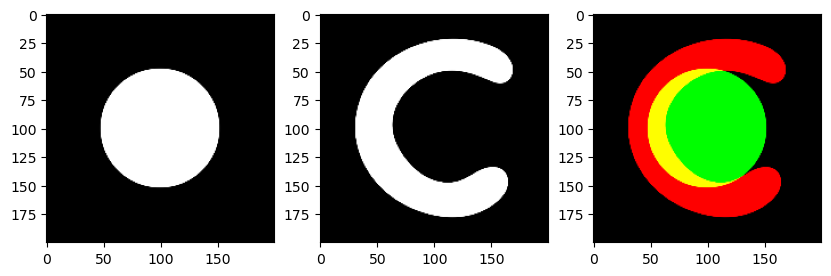

In [2]:
import torch
#from torch.utils.checkpoint import checkpoint # redondant mais necéssaire ...
import kornia.filters as flt
import matplotlib.pyplot as plt
import time
from math import log

from my_toolbox import update_progress,format_time
from constants import *
%load_ext autoreload
%autoreload 2
import my_torchbox as tb
import vector_field_to_flow as vff
import metamorphosis as mt

#Picture Opening
plt.rcParams['figure.figsize'] = [10,20]
size = (200,200) # You can set the size here, put None if you want to use the original size
S = tb.reg_open('08',size = size) 
T = tb.reg_open('m0',size = size) 
if size is None:
    _,_,H,W = S.shape
    size = (H,W)
else:
    H,W = size

# To blur the pictures with a gaussian kernel of sigma = 3
# sig = 3
# smooth = flt.GaussianBlur2d((sig*3,sig*3), (sig, sig))
# S = smooth(S)
# T = smooth(T)



id_grid = tb.make_regular_grid(size)

# You can try different initial residuals 

residuals = torch.zeros(size)
# # the difference of the source and target image is an interesting initialisation
# residuals = (T - S)[0,0,:,:]
# # to start over with a already initialized residual.
# # residuals = mr_1.to_analyse[0]
residuals.requires_grad = True
residuals.to('cuda:0')

# Show the pictures open
plt.rcParams['figure.figsize'] = [10,30]
fig,ax = plt.subplots(1,3)
ax[0].imshow(S[0,0,:,:],cmap='gray',vmin=0,vmax=1)
ax[1].imshow(T[0,0,:,:],cmap='gray',vmin=0,vmax=1)
ax[2].imshow(tb.imCmp(S,T),vmin=0,vmax=1)
plt.show()

To prepare the figure, in the article we decided to use a well chosen initial $z$ to demonstrate the shootings.
 To do so we ran the optimisation process. These cells are for this purpose.

You can run the optimisation by yourself, or load the result in the next cell if you don't want to wait for the optimisation to finish. (Loading works only for the example we provide) 

Progress: [##########] 100.00% Done...  ,  406.33).
 (ssd :  ,  406.75).
Computation of lddmm done in  0:02:37s and 0.639cents  s


AttributeError: module 'my_torchbox' has no attribute 'pixel2square_convention'

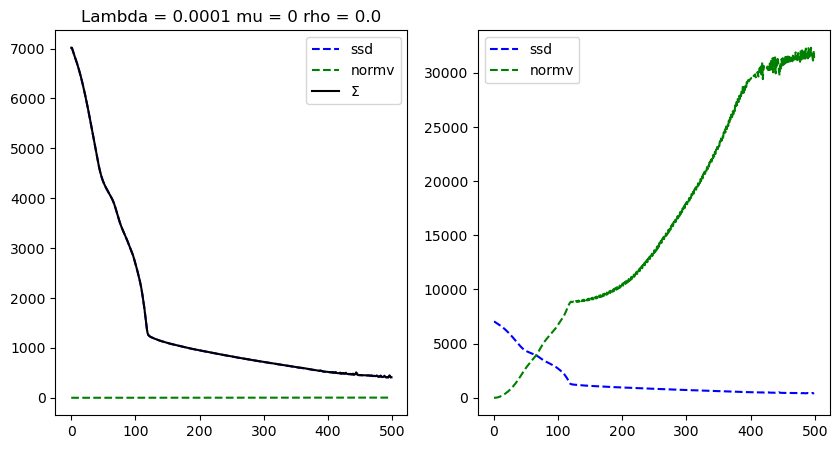

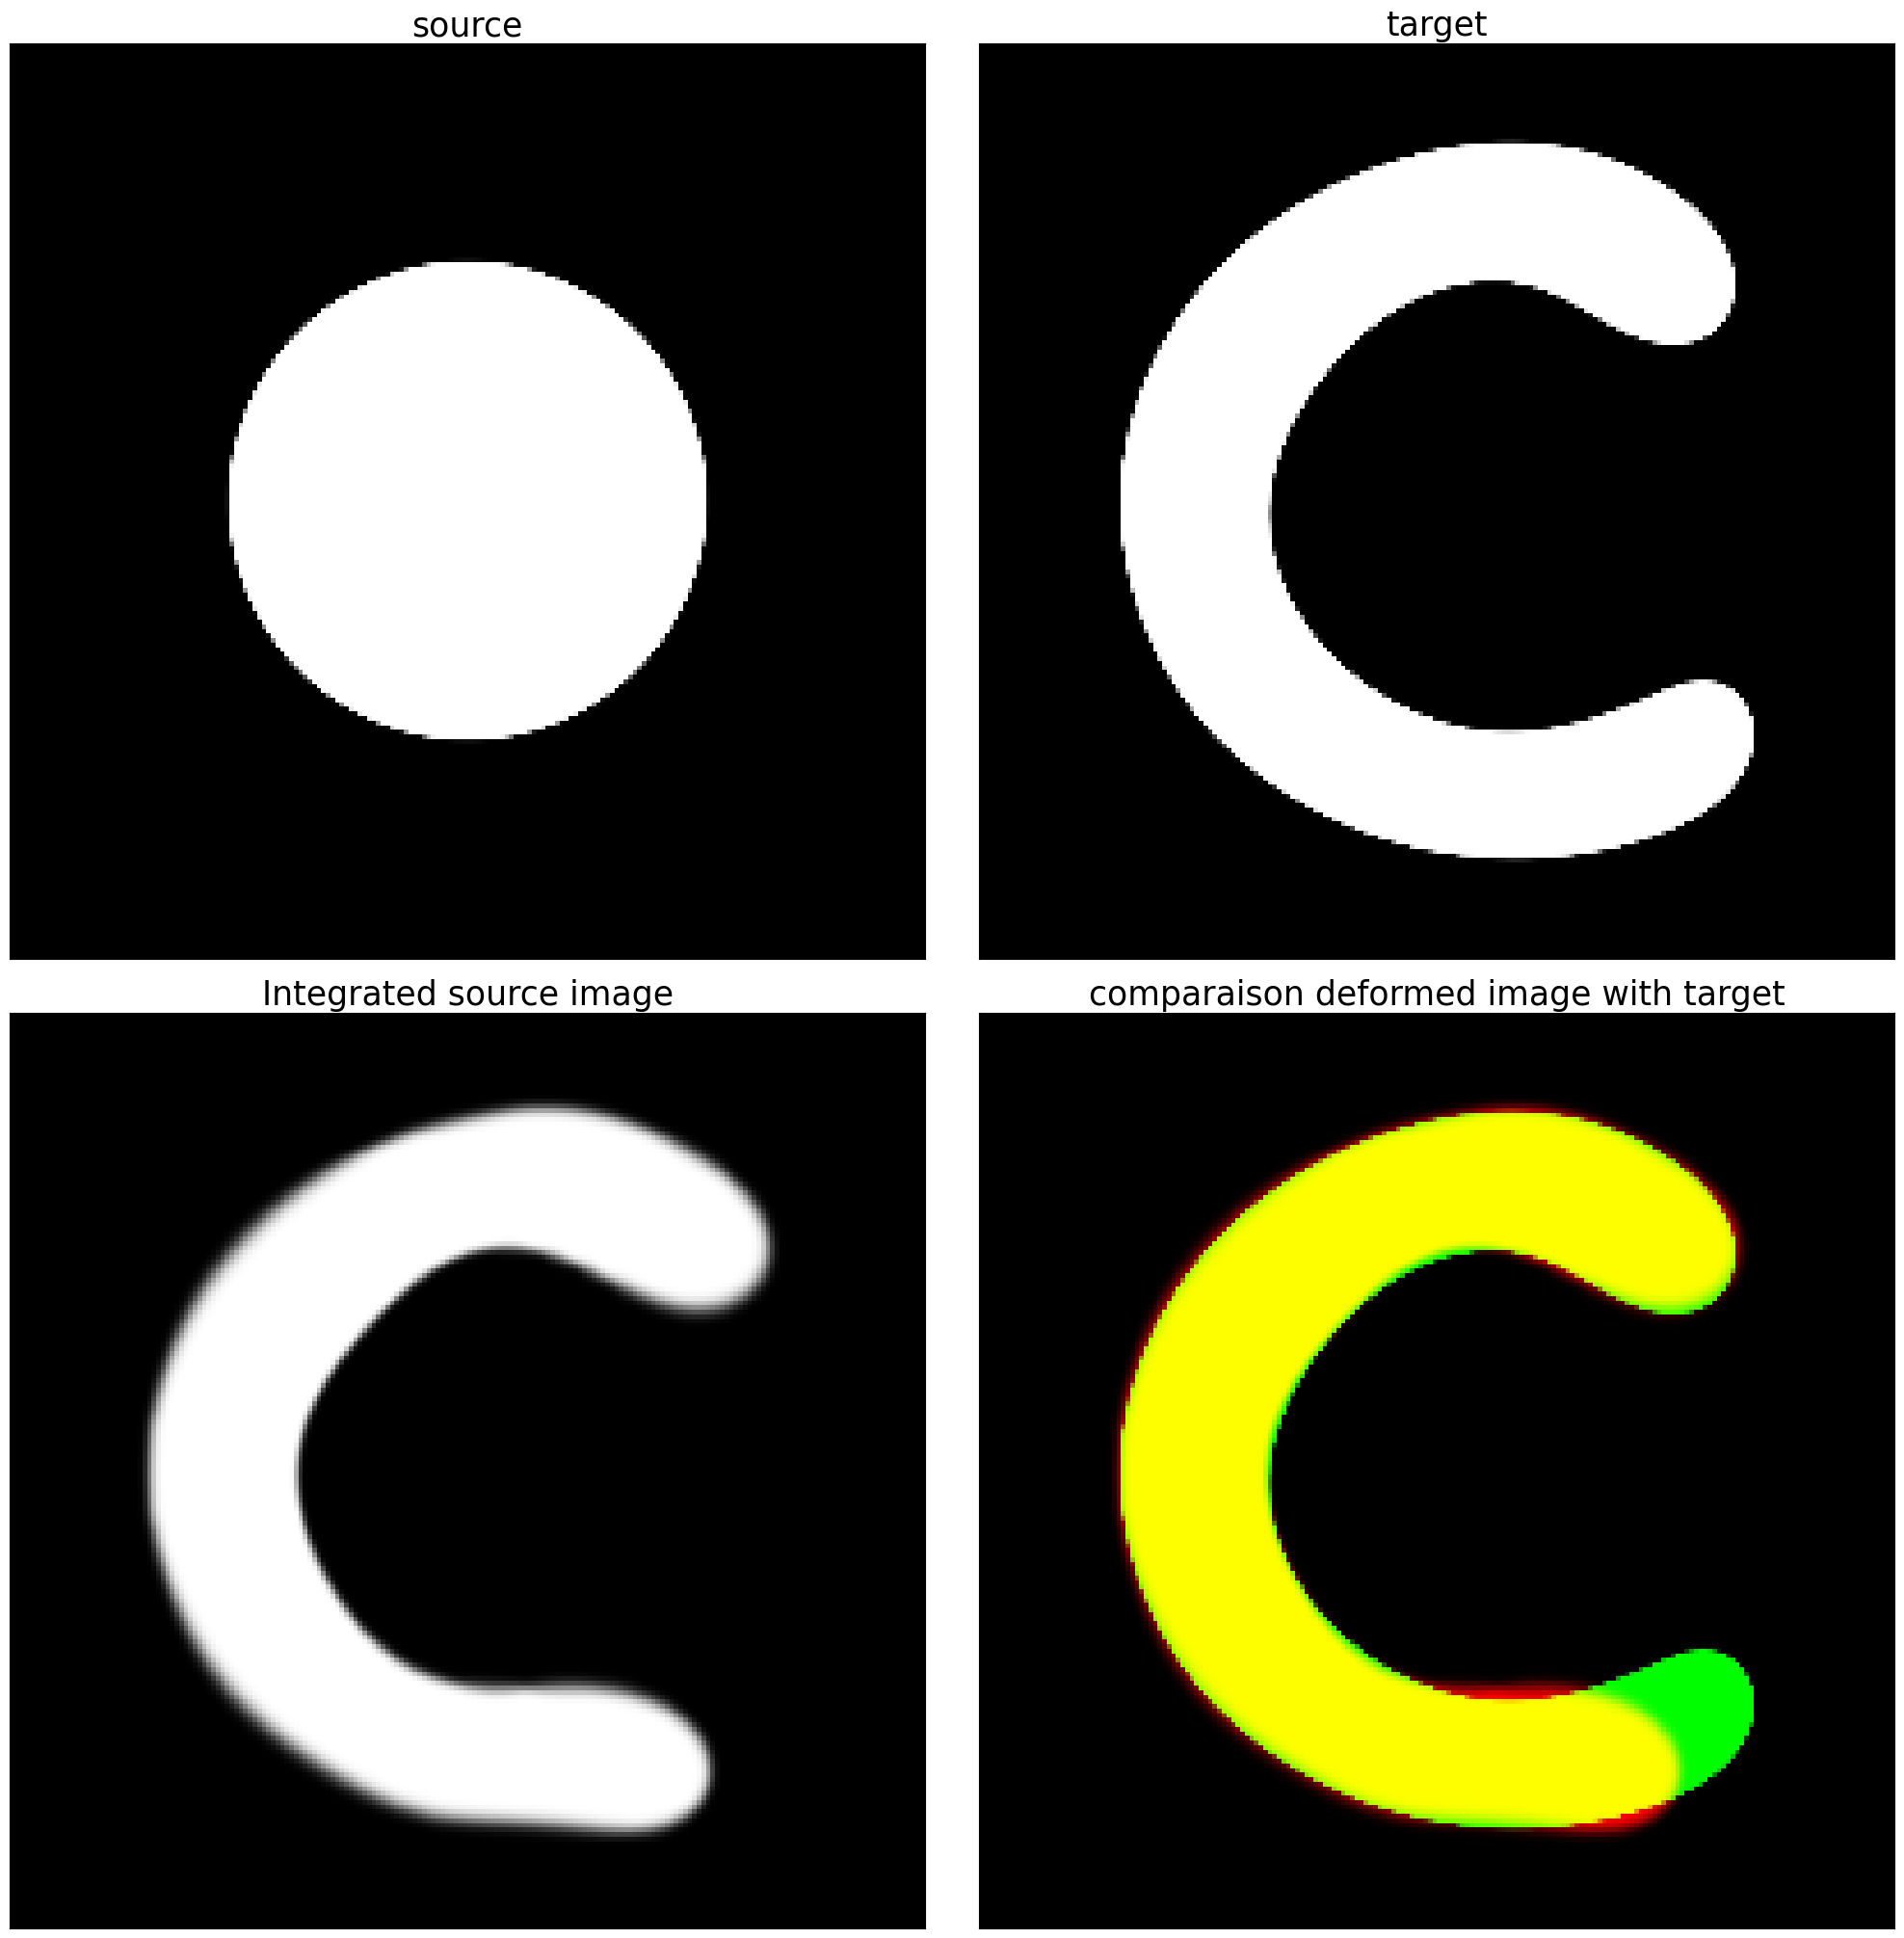

In [3]:
residuals = torch.zeros(size)
# # to start over with a already initialized residual.
# # residuals = mr_1.to_analyse[0]
residuals.requires_grad = True
residuals.to('cuda:0')


lamb = 1e-4
n_iter = 500
sigma=15


mr_L = mt.lddmm(S,T,0,sigma=sigma, cost_cst=lamb,integration_steps=20, n_iter=n_iter,grad_coef=10)



mr_L.plot()
mr_L.plot_deform()

In [4]:
mr_L.save('08','m0')

TypeError: _write_dict_to_csv() got an unexpected keyword argument 'path'


The chosen initial residual is :

residuals min -34.97328567504883 max 111.49750518798828, resi_val 111.49750518798828


[]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


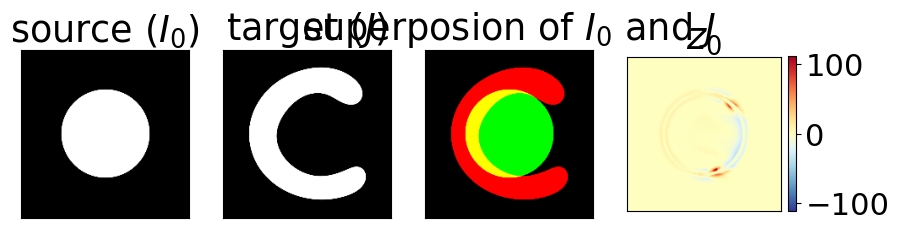

In [5]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 22})

residuals = mr_L.to_analyse[0]
residuals.requires_grad = True
residuals.to('cuda')
resi_val = max(abs(residuals.min()),abs(residuals.max()))
print(f"residuals min {residuals.min()} max {residuals.max()}, resi_val {resi_val}")

kw_image_args = dict(cmap='gray',
                      extent=[-1,1,-1,1],
                      origin='lower',
                      vmin=0,vmax=1)
kw_residuals_args = dict(cmap='RdYlBu_r',
                      extent=[-1,1,-1,1],
                      origin='lower',
                      vmin=-resi_val,vmax=resi_val,   )

fig,ax = plt.subplots(1,4)
ax[0].imshow(S[0,0,:,:],**kw_image_args)
ax[0].set_title(r'source ($I_0$)')

ax[1].imshow(T[0,0,:,:],**kw_image_args)
ax[1].set_title(r'target ($J$)')

ax[2].imshow(tb.imCmp(S,T),**kw_image_args)
ax[2].set_title(r'superposion of $I_0$ and $J$')

r_ini =ax[3].imshow(residuals[0,0].detach(),**kw_residuals_args)
fig.colorbar(r_ini,ax=ax[3],
        fraction=0.046, pad=0.04)
ax[3].set_title(r'$z_0$')
plt.setp(ax, xticks=[], yticks=[])


In [6]:
mu = 0

sigma = 15
# set plot to a positive integer to see geodesic integrations
plot = 0

start = time.time()
mp_E = mt.Metamorphosis_path(method='Eulerian',
                             mu=mu,sigma_v=(sigma,sigma),
                             n_step=1000)
mp_E.forward(S.clone(),residuals.clone(),plot=plot,verbose=True)
end = time.time()
print('Eulerian time : ',format_time(end-start))

Progress: [----------]   2.50% 

/home/turtlefox/Documents/Doctorat/Demeter/metamorphosis.py:1189: UserWarning: mu as been set to zero in methamorphosis_path, automatic reset of rho to zero.
  if(mu == 0 and rho != 0):


Progress: [##########]  99.90% Eulerian time :  0:00:07s and 0.047cents


In [8]:
start = time.time()
mp_aL = mt.Metamorphosis_path(method='advection_semiLagrangian',
                              mu=mu,sigma_v=(sigma,sigma),n_step=20)
mp_aL.forward(S.clone(),residuals.clone(),plot=plot)
end = time.time()
print('advection semi-Lagrangian time : ',format_time(end-start))

start = time.time()
mp_L = mt.Metamorphosis_path(method='semiLagrangian',
                             mu=mu,sigma_v=(sigma,sigma),n_step=20)
mp_L.forward(S.clone(),residuals.clone(),plot=plot)
end = time.time()
print('semi-Lagrangian time : ',format_time(end-start))


temporal_integrator = vff.FieldIntegrator(method='temporal',
                                            save=False,
                                            dx_convention='pixel')

E_deformation = temporal_integrator(mp_E.field_stock/mp_E.n_step,forward=True)
aL_deformation = temporal_integrator(mp_aL.field_stock/mp_aL.n_step,forward=True)
L_deformation = temporal_integrator(mp_L.field_stock/mp_L.n_step,forward=True)

advection semi-Lagrangian time :  0:00:00s and 0.102cents
semi-Lagrangian time :  0:00:00s and 0.105cents


AttributeError: module 'my_torchbox' has no attribute 'pixel2square_convention'

The figure as it is computed here present some instabilities, try increasing n_step 

In [9]:
plot_id = torch.quantile(torch.arange(mp_L.n_step,dtype=torch.float),
                                 torch.linspace(0,1,4)).round().int()
# plot_id= plot_id[1:]
plot_id_E = torch.quantile(torch.arange(mp_E.n_step,dtype=torch.float),
                                 torch.linspace(0,1,4)).round().int()
# plot_id_E= plot_id_E[1:]
%matplotlib qt
size_fig = 5
step = int(min(mp_E.field_stock.shape[2:-1])/30)
plt.rcParams['figure.figsize'] = [size_fig*5,6*size_fig]
fig_me,ax_me = plt.subplots(6,5)

for i,t in enumerate(plot_id_E):
    i_1 =ax_me[0,i].imshow(mp_E.image_stock[t,0,:,:].detach().numpy(),
            **kw_image_args)
    ax_me[0,i].set_title(r"$I_t$ for $t =$ "+str((t/(mp_E.n_step-1)).item())[:3])
    fig_me.colorbar(i_1,ax=ax_me[0,i],fraction=0.046, pad=0.04)

    r_1 =ax_me[1,i].imshow(mp_E.residuals_stock[t,0,:,:].detach().numpy(),
            **kw_residuals_args)
    ax_me[1,i].set_title(r"$z_t$ for $t = $"+str((t/(mp_E.n_step-1)).item())[:3])
    fig_me.colorbar(r_1,ax=ax_me[1,i],fraction=0.046, pad=0.04)

# ax_me[0,-1].imshow(tb.imCmp(mp_E.image,T))
# ax_me[0,-1].set_title(r"Comparaison $I_1$ vs $J$")



tb.gridDef_plot(E_deformation,ax = ax_me[1,-1],step=step, dx_convention='pixel')
ax_me[1,-1].set_title(r"$\Phi_1$")

for i,t in enumerate(plot_id):
    i_2 =ax_me[2,i].imshow(mp_aL.image_stock[t,0,:,:].detach().numpy(),
            **kw_image_args)
    ax_me[2,i].set_title(r"$I_t$ for $t =$ "+str((t/(mp_aL.n_step-1)).item())[:3])
    fig_me.colorbar(i_2,ax=ax_me[2,i],fraction=0.046, pad=0.04)

    r_2 =ax_me[3,i].imshow(mp_aL.residuals_stock[t,0,:,:].detach().numpy(),
            **kw_residuals_args)
    ax_me[3,i].set_title(r"$z_t$ for $t = $"+str((t/(mp_aL.n_step-1)).item())[:3])
    fig_me.colorbar(r_2,ax=ax_me[3,i],fraction=0.046, pad=0.04)

    i_3 =ax_me[4,i].imshow(mp_L.image_stock[t,0,:,:].detach().numpy(),
            **kw_image_args)
    ax_me[4,i].set_title(r"$I_t$ for $t =$ "+str((t/(mp_aL.n_step-1)).item())[:3])
    fig_me.colorbar(i_3,ax=ax_me[4,i],fraction=0.046, pad=0.04)

    r_3 =ax_me[5,i].imshow(mp_L.residuals_stock[t,0,:,:].detach().numpy(),
            **kw_residuals_args)
    ax_me[5,i].set_title(r"$z_t$ for $t = $"+str((t/(mp_L.n_step-1)).item())[:3])
    fig_me.colorbar(r_3,ax=ax_me[5,i],fraction=0.046, pad=0.04)

# ax_me[2,-1].imshow(tb.imCmp(mp_aL.image,T))
# ax_me[2,-1].set_title(r"Comparaison $I_1$ vs J")
tb.gridDef_plot(aL_deformation,ax = ax_me[3,-1],step=step, dx_convention='pixel')
ax_me[3,-1].set_title(r"$\Phi_1$")

# ax_me[4,-1].imshow(tb.imCmp(mp_L.image,T))
# ax_me[4,-1].set_title(r"Comparaison $I_1$ vs T")
tb.gridDef_plot(L_deformation,ax = ax_me[5,-1],step=step, dx_convention='pixel')
ax_me[5,-1].set_title(r"$\Phi_1$")

plt.setp(ax_me, xticks=[], yticks=[])

/tmp/ipykernel_124336/1809335084.py:29: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(E_deformation,ax = ax_me[1,-1],step=step, dx_convention='pixel')
/tmp/ipykernel_124336/1809335084.py:55: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(aL_deformation,ax = ax_me[3,-1],step=step, dx_convention='pixel')
/tmp/ipykernel_124336/1809335084.py:60: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(L_deformation,ax = ax_me[5,-1],step=step, dx_convention='pixel')


[]

In [15]:
from constants import *
mp_L.save_to_gif('image','semiLagrangian',folder='stability',clean=False)

[autoreload of metamorphosis failed: Traceback (most recent call last):
  File "/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 839, in exec_module
  File "<frozen importlib._bootstrap_external>", line 976, in get_code
  File "<frozen importlib._bootstrap_external>", line 906, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/turtlefox/Documents/Doctorat/Demeter/metamorphosis.py", lin

TypeError: save_to_gif() got an unexpected keyword argument 'clean'